In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sympy as sp
import statsmodels.stats as sms
from linearmodels import IV2SLS, IV3SLS
from sklearn.metrics import r2_score

Были загружены данные о демографической обстановки в Российской Федерации с 1991 года по 2022 год

In [3]:
data = pd.read_excel('Данные демография экон.xlsx', usecols = range(1, 15))
data.head()

,Браков на 1000 чел,Коэф. Рожд,Коэф. Смерт,Коэф. Миграц,Заболеваемость,удельный вес населения старше трудоспособного возраста,населения в трудоспособном возрасте,численность экономически активного населения,Безработица,Средняя номинальная зарплата,инвестиции в жил,кв м на 1 чел,охват дошкол обр,загрязнение
0,8.6,12.1,11.4,172.2,603.8,16.5,50.70,74145,5.1,0.548,12.249600,16.5,63.9,31801.0
1,7.1,10.7,12.2,252.9,614.6,17.0,54.67,75060,5.2,6.000,64.051200,16.8,56.8,28207.0
2,7.5,9.4,14.5,440.3,676.0,17.3,52.46,70740,5.9,58.700,226.041050,17.4,57.4,24788.3
3,7.4,9.6,15.7,845.7,646.5,17.5,52.05,72332,8.1,220.400,554.930056,17.7,56.2,21929.0
4,7.3,9.3,15.1,519.5,671.4,17.8,49.23,72421,9.4,472.400,1026.902195,18.1,55.5,21269.6


Была построена матрица корреляции для данных и выделены столбцы с экзогенными переменными

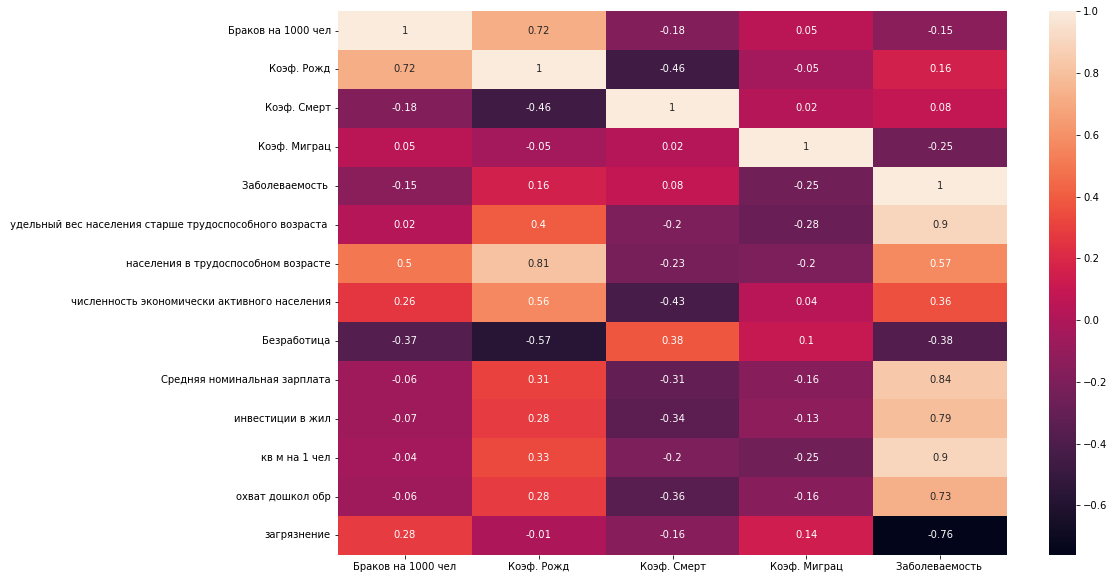

In [4]:
plt.figure(figsize = (15, 10))
sns.heatmap(np.round(data.corr().iloc[:, :5], 2), annot = True)
plt.show()

In [27]:
C = np.linalg.inv(data.corr())
k = data.shape[1]
par_corr = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        par_corr[i, j] = - C[i, j] / (C[i, i] * C[j, j])**(1/2)
par_corr = pd.DataFrame(par_corr, index = data.columns, columns = data.columns)

Была построена матрица частных коэффициентов корреляции

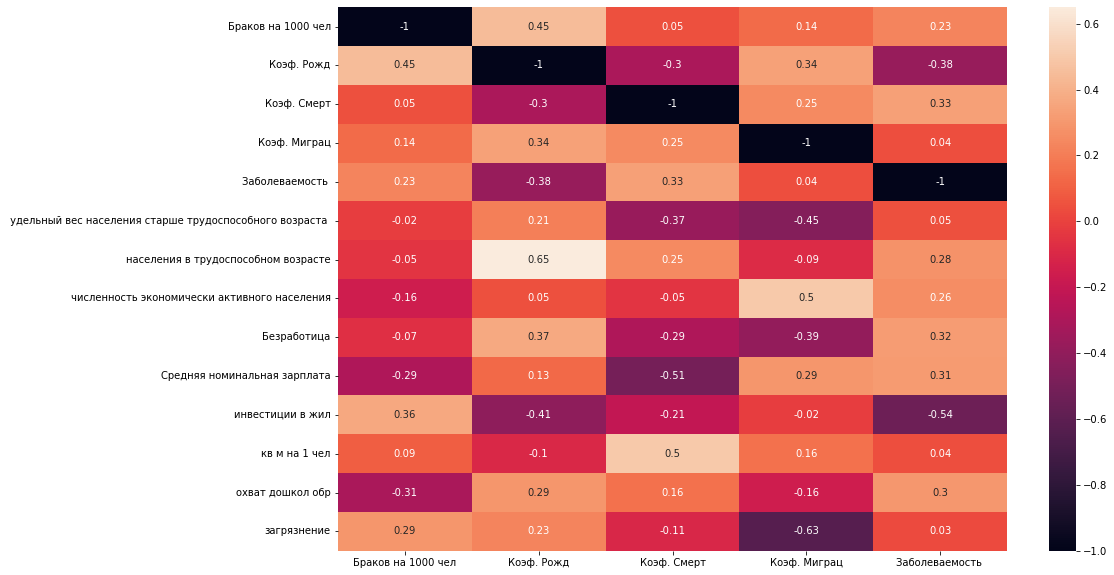

In [158]:
plt.figure(figsize = (15, 10))
sns.heatmap(np.round(par_corr.iloc[:, :5], 2), annot = True)
plt.show()

# Зависимые (целевые) переменные
- **Y1:** Браков на 1000 чел
- **Y2:** Коэффициент рождаемости
- **Y3:** Коэффициент смертности
- **Y4:** Коэффициент миграции
- **Y5:** Заболеваемость

# Независимые переменные
- **X1:** Удельный вес населения старше трудоспособного возраста
- **X2:** Население в трудоспособном возрасте
- **X3:** Численность экономически активного населения
- **X4:** Безработица
- **X5:** Средняя номинальная зарплата
- **X6:** Инвестиции в жилое строительство
- **X7:** Квадратные метры жилья на 1 человека
- **X8:** Охват дошкольным образованием
- **X9:** Загрязнение окружающей среды

In [68]:
Y1 = data['Браков на 1000 чел']
Y2 = data['Коэф. Рожд']
Y3 = data['Коэф. Смерт']
Y4 = data['Коэф. Миграц']
Y5 = data['Заболеваемость ']
X1 = data[' удельный вес населения старше трудоспособного возраста ']
X2 = data['населения в трудоспособном возрасте']
X3 = data['численность экономически активного населения']
X4 = data['Безработица']
X5 = data['Средняя номинальная зарплата']
X6 = data['инвестиции в жил']
X7 = data['кв м на 1 чел']
X8 = data['охват дошкол обр']
X9 = data['загрязнение']

На основе данных о корреляции были построены модели линейной регрессии, самые лучшие модели были оставлены

In [69]:
exog1 = pd.concat([X2, X5], axis = 1)
ord_model_1 = sm.OLS(Y1[:-5], exog1[:-5]).fit()
print(ord_model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:     Браков на 1000 чел   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1599.
Date:                Sun, 26 May 2024   Prob (F-statistic):                    4.17e-27
Time:                        21:25:00   Log-Likelihood:                         -27.269
No. Observations:                  27   AIC:                                      58.54
Df Residuals:                      25   BIC:                                      61.13
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [70]:
sms.diagnostic.het_breuschpagan(ord_model_1.resid, exog1[:-5])

(8.47479887421053,
 0.0036010019542173687,
 5.718425684467006,
 0.009015495376334044)

Для всех параметров p-value t статистик < 0.05, значит H0 отвергается, следовательно параметры значимы  
F статистика больше табличного значения, значит H0 отвергается, следовательно уравнение значимо  
p-value теста Харке-Бера > 0.05, значит H0 не отвергается, следовательно остатки распределены нормально  
p-value теста Бреуша Пагана < 0.05, значит H0 отвергается, следовательно распределение остатков гетероскедастично    
Статистика Дарбина-Уотсона < dl, следовательно наблюдается положительная автокорреляция  

In [71]:
exog2 = pd.concat([Y1, X2], axis = 1)
ord_model_2 = sm.OLS(Y2[:-5], exog2[:-5]).fit()
print(ord_model_2.summary())

                                 OLS Regression Results                                
Dep. Variable:             Коэф. Рожд   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2474.
Date:                Sun, 26 May 2024   Prob (F-statistic):                    1.85e-29
Time:                        21:25:02   Log-Likelihood:                         -31.484
No. Observations:                  27   AIC:                                      66.97
Df Residuals:                      25   BIC:                                      69.56
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [72]:
sms.diagnostic.het_breuschpagan(ord_model_2.resid, exog2[:-5])

(14.272363055947393,
 0.0001581702510942693,
 14.017098302187797,
 8.266090961662476e-05)

Для всех параметров p-value t статистик < 0.05, значит H0 отвергается, следовательно параметры значимы  
F статистика больше табличного значения, значит H0 отвергается, следовательно уравнение значимо  
p-value теста Харке-Бера > 0.05, значит H0 не отвергается, следовательно остатки распределены нормально  
p-value теста Бреуша Пагана < 0.05, значит H0 отвергается, следовательно распределение остатков гетероскедастично    
Статистика Дарбина-Уотсона < dl, следовательно наблюдается положительная автокорреляция  

In [73]:
exog3 = pd.concat([Y5, X5], axis = 1)
ord_model_3 = sm.OLS(Y3[:-5], exog3[:-5]).fit()
print(ord_model_3.summary())

                                 OLS Regression Results                                
Dep. Variable:            Коэф. Смерт   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              3532.
Date:                Sun, 26 May 2024   Prob (F-statistic):                    2.20e-31
Time:                        21:25:04   Log-Likelihood:                         -33.890
No. Observations:                  27   AIC:                                      71.78
Df Residuals:                      25   BIC:                                      74.37
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [74]:
sms.diagnostic.het_breuschpagan(ord_model_3.resid, exog3[:-5])

(12.102301741750432,
 0.0005035961844142824,
 10.154506363968682,
 0.0005914834801198633)

Для всех параметров p-value t статистик < 0.05, значит H0 отвергается, следовательно параметры значимы  
F статистика больше табличного значения, значит H0 отвергается, следовательно уравнение значимо  
p-value теста Харке-Бера > 0.05, значит H0 не отвергается, следовательно остатки распределены нормально  
p-value теста Бреуша Пагана < 0.05, значит H0 отвергается, следовательно распределение остатков гетероскедастично    
Статистика Дарбина-Уотсона < dl, следовательно наблюдается положительная автокорреляция  

In [75]:
exog5 = pd.concat([X1, X4, X8], axis = 1)
ord_model_5 = sm.OLS(Y5[:-5], exog5[:-5]).fit()
print(ord_model_5.summary())

                                 OLS Regression Results                                
Dep. Variable:        Заболеваемость    R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.085e+04
Date:                Sun, 26 May 2024   Prob (F-statistic):                    1.03e-37
Time:                        21:25:05   Log-Likelihood:                         -119.11
No. Observations:                  27   AIC:                                      244.2
Df Residuals:                      24   BIC:                                      248.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                                               coef    std err          t      P>|t|      [0.025      0.

In [76]:
sms.diagnostic.het_breuschpagan(ord_model_5.resid, exog5[:-5])

(12.3174282054511,
 0.00211497115954554,
 6.711319176398842,
 0.0019003317437399827)

Для всех параметров p-value t статистик < 0.05, значит H0 отвергается, следовательно параметры значимы  
F статистика больше табличного значения, значит H0 отвергается, следовательно уравнение значимо  
p-value теста Харке-Бера > 0.05, значит H0 не отвергается, следовательно остатки распределены нормально  
p-value теста Бреуша Пагана < 0.05, значит H0 отвергается, следовательно распределение остатков гетероскедастично    
Статистика Дарбина-Уотсона < dl, следовательно наблюдается положительная автокорреляция  

In [80]:
Y1_pred = ord_model_1.predict(pd.concat([X2, X5], axis = 1)[-5:])
Y2_pred = ord_model_2.predict(pd.concat([Y1_pred, X2[-5:]], axis = 1))
Y5_pred = ord_model_5.predict(pd.concat([X1, X4, X8], axis = 1)[-5:])
Y3_pred = ord_model_3.predict(pd.concat([Y5_pred, X5[-5:]], axis = 1))

In [81]:
Y_all = pd.concat([Y1[-5:], Y2[-5:], Y3[-5:], Y5[-5:]])
Y_all_pred = pd.concat([Y1_pred, Y2_pred, Y3_pred, Y5_pred])
r2_score(Y_all, Y_all_pred)

0.994684689974881

R2 = 0.9946 на тестовой выборке, что говорит о хорошей предсказательной способности модели

В ходе построений моделей для коэффициента миграции не получилось построить значимой модели, поэтому было решено его не учитывать

В ходе работы были получены следующие переменные

## Зависимые (целевые) переменные
- **Y1:** Браков на 1000 чел
- **Y2:** Коэффициент рождаемости
- **Y3:** Коэффициент смертности
- **Y4:** Заболеваемость

## Независимые переменные
- **X1:** Удельный вес населения старше трудоспособного возраста
- **X2:** Население в трудоспособном возрасте
- **X3:** Безработица
- **X4:** Средняя номинальная зарплата
- **X5:** Охват дошкольным образованием

In [37]:
Y1 = data['Браков на 1000 чел'].rename('Y1')
Y2 = data['Коэф. Рожд'].rename('Y2')
Y3 = data['Коэф. Смерт'].rename('Y3')
Y4 = data['Заболеваемость '].rename('Y4')
X1 = data[' удельный вес населения старше трудоспособного возраста '].rename('X1')
X2 = data['населения в трудоспособном возрасте'].rename('X2')
X3 = data['Безработица'].rename('X3')
X4 = data['Средняя номинальная зарплата'].rename('X4')
X5 = data['охват дошкол обр'].rename('X5')

Спецификация модели

$Y_1 = b_{11}*X_2 + b_{12}*X_4 + ε_1$  

$Y_2 = b_{21}*Y_1 + b_{22}*X_2 + ε_2$ 

$Y_3 = b_{31}*Y_4 + b_{32}*X_4 + ε_3$ 

$Y_4 = b_{41}*X_1 + b_{42}*X_3 + b_{43}*X_5 + ε_4$

Метод порядка  

1) 1 < 3 - 1 = 2 - уравнение сверхиндентифицируемо  
2) 2 < 4 - 1 = 3 - сверхиндентифицируемо  
3) 2 < 4 - 1 = 3 - уравнение сверхиндентифицируемо   
4) 1 = 2 - 1 = 1- уравнение точно индентифицируемо   

In [10]:
b11, b12, b21, b22, b31, b32, b41, b42, b43, v1, v2, v3, v4 = sp.symbols('b11, b12, b21, b22, b31, b32, b41, b42, b43, v1, v2, v3, v4')
A = sp.Matrix([[1, 0, 0, 0],
               [-b21, 1, 0, 0],
               [0, 0, 1, -b31],
               [0, 0, 0, 1]])
B = sp.Matrix([[0, -b11, 0, -b12, 0],
               [0, -b22, 0, 0, 0],
               [0, 0, 0, -b32, 0],
               [-b41, 0, -b42, 0, -b43]])
AB = sp.Matrix.hstack(A, B)

In [11]:
AB

Matrix([
[   1, 0, 0,    0,    0, -b11,    0, -b12,    0],
[-b21, 1, 0,    0,    0, -b22,    0,    0,    0],
[   0, 0, 1, -b31,    0,    0,    0, -b32,    0],
[   0, 0, 0,    1, -b41,    0, -b42,    0, -b43]])

In [12]:
R1 = sp.Matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1]])
R2 = sp.Matrix([[0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1]])
R3 = sp.Matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1]])
R4 = sp.Matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [13]:
(AB * R1.T).rank()

3

3 = 4 - 1, тогда 1 уравнение идентифицируемо

In [14]:
(AB * R2.T).rank()

3

3 = 4 - 1, тогда 1 уравнение идентифицируемо

In [15]:
(AB * R3.T).rank()

3

3 = 4 - 1, тогда 1 уравнение идентифицируемо

In [16]:
(AB * R3.T).rank()

3

3 = 4 - 1, тогда 1 уравнение идентифицируемо

## Трехшаговый МНК

In [59]:
data_for_model = pd.concat([Y1, Y2, Y3, Y4, X1, X2, X3, X4, X5], axis = 1)[:-5]

In [60]:
eq1 = "Y1 ~ X2 + X4"
eq2 = "Y2 ~ Y1 + X2"
eq3 = "Y3 ~ Y4 + X4"
eq4 = "Y4 ~ X1 + X3 + X5"
equations = dict(eq1=eq1, eq2=eq2, eq3=eq3, eq4=eq4)
system_3sls = IV3SLS.from_formula(equations, data_for_model)
system_3sls_res = system_3sls.fit(method="gls", cov_type="heteroskedastic")
print(system_3sls_res)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.9992
No. Equations.:                     4   McElroy's R-squared:                 0.8582
No. Observations:                  27   Judge's (OLS) R-squared:             0.8466
Date:                Sun, May 26 2024   Berndt's R-squared:                  0.9772
Time:                        21:03:52   Dhrymes's R-squared:                 0.9992
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                    Equation: eq1, Dependent Variable: Y1                     
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X2             0.1384     0.0032     43.148     0.0000      0.1321      0.1446
X4         -

In [62]:
par = system_3sls_res.params
par

eq1_X2     0.138356
eq1_X4    -0.000026
eq2_Y1     0.300204
eq2_X2     0.152834
eq3_Y4     0.021122
eq3_X4    -0.000100
eq4_X1    24.793684
eq4_X3     8.847740
eq4_X5     2.640649
Name: params, dtype: float64

Для всех параметров p-value t статистик < 0.05, значит H0 отвергается, следовательно параметры значимы  
R2 = 0.9992, что говорит об хорошем качестве модели

После применения Трехшагового МНК были получены следующие оценки  

$\hat{Y_1} = 0.1384*X_2 + -2.575e^{-05}*X_4$  

$\hat{Y_2} = 0.3002*Y_1 + 0.1528*X_2$ 

$\hat{Y_3} = 0.0211*Y_4 + -0.0001*X_4$ 

$\hat{Y_4} = 24.794*X_1 + 8.8477*X_3 + 2.6406*X_5$

пердсказания модели

In [66]:
Y1_pred = par['eq1_X2'] * X2[-5:] + par['eq1_X4'] * X4[-5:]
Y2_pred =  par['eq2_Y1'] * Y1_pred + par['eq2_X2'] * X2[-5:]
Y4_pred = par['eq4_X1'] * X1[-5:] + par['eq4_X3'] * X3[-5:] + par['eq4_X5'] * X5[-5:]
Y3_pred = par['eq3_Y4'] * Y4_pred + par['eq3_X4'] * X4[-5:]

In [67]:
Y_all = pd.concat([Y1[-5:], Y2[-5:], Y3[-5:], Y4[-5:]])
Y_all_pred = pd.concat([Y1_pred, Y2_pred, Y3_pred, Y4_pred])
r2_score(Y_all, Y_all_pred)

0.9949582149412861

R2 = 0.9949 на тестовой выборке, что говорит о хорошей предсказательной способности модели

Вторая модель лучше